# Neural Machine Translation (seq2seq): From English to French
This file is modified from the original file named "lstm_seq2seq.py", downloaded from [keras-examples](https://github.com/keras-team/keras/tree/master/examples).

Other reference
- [tensorflow-nmt](https://github.com/tensorflow/nmt).
- [attention-based-seq2seq-from-English-to-Janpanese-in-keras](https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html).
- [attention-based-seq2seq for Spanish to English translation using tf.keras](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb).

Jun 24, 2019.

guorui233@outlook.com

+ [keras.layers.LSTM](https://github.com/keras-team/keras/blob/master/keras/layers/recurrent.py#L2051) is a class and will define a LSTM layer instead of a cell.

In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import TensorBoard
from time import time
from keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import io
time_begin = time()

Using TensorFlow backend.


## 1 - Prepare Data

In [2]:
latent_dim = 256  # Dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with io.open('fra.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [4]:
for line in lines[:num_samples]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [5]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_enc_tokens = len(input_characters)
num_dec_tokens = len(target_characters)
max_enc_seq_len = max([len(txt) for txt in input_texts])
max_dec_seq_len = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_enc_tokens)
print('Number of unique output tokens:', num_dec_tokens)
print('Max sequence length for inputs:', max_enc_seq_len)
print('Max sequence length for outputs:', max_dec_seq_len)

('Number of samples:', 10000)
('Number of unique input tokens:', 70)
('Number of unique output tokens:', 93)
('Max sequence length for inputs:', 16)
('Max sequence length for outputs:', 59)


In [6]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])

target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# len(input_texts)=10000, max_enc_seq_len=16, num_enc_tokens=70
enc_in_data = np.zeros(
    (len(input_texts), max_enc_seq_len, num_enc_tokens),
    dtype='float32')

# len(input_texts)=10000, max_dec_seq_len=59, num_dec_tokens=93
dec_in_data = np.zeros(
    (len(input_texts), max_dec_seq_len, num_dec_tokens),
    dtype='float32')

# len(input_texts)=10000, max_dec_seq_len=59, num_dec_tokens=93
dec_target_data = np.zeros(
    (len(input_texts), max_dec_seq_len, num_dec_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        enc_in_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # dec_target_data is ahead of dec_in_data by one timestep
        dec_in_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # dec_target_data will be ahead by one timestep
            # and will not include the start character.
            dec_target_data[i, t - 1, target_token_index[char]] = 1.

## 2 - Build and Train the Seq2seq Model

In [7]:
# Define an input sequence and process it.
enc_in = Input(shape=(None, num_enc_tokens), 
                       name='enc_in') # num_enc_tokens=70
enc_lstm = LSTM(units=latent_dim, 
               return_state=True, 
               name='enc_lstm') # latent_dim = 256
enc_outputs, state_h, state_c = enc_lstm(enc_in)
# We discard `enc_outputs` and only keep the states.
enc_states = [state_h, state_c]

# Set up the decoder, using `enc_states` as initial state.
dec_in = Input(shape=(None, num_dec_tokens),
                       name='dec_in') # num_dec_tokens=93
dec_lstm = LSTM(latent_dim, 
                return_sequences=True, 
                return_state=True,
                name='dec_lstm')
dec_outputs, _, _ = dec_lstm(dec_in,
                                     initial_state=enc_states)

# num_dec_tokens=93, from latent_dim=256 to 93
dec_dense = Dense(units=num_dec_tokens, activation='softmax', name='dec_dense')
dec_outputs = dec_dense(dec_outputs)


In [8]:
# Define the model that will turn
# `enc_in_data` & `dec_in_data` into `dec_target_data`
model = Model([enc_in, dec_in], dec_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
tbCallBack = TensorBoard(log_dir='./Graph', # stored in the folder `Graph`
                         histogram_freq=0,
                         write_graph=True,
                         write_images=True)

In [9]:
model_history = model.fit([enc_in_data, dec_in_data], dec_target_data,
                          batch_size=64,
                          epochs=20,
                          validation_split=0.2,
                          callbacks=[tbCallBack])

Train on 8000 samples, validate on 2000 samples
Epoch 1/20
8000/8000 [==============================] - 9s 1ms/step - loss: 0.9123 - val_loss: 0.9240
Epoch 2/20
8000/8000 [==============================] - 8s 956us/step - loss: 0.7238 - val_loss: 0.7643
Epoch 3/20
8000/8000 [==============================] - 8s 972us/step - loss: 0.6183 - val_loss: 0.6853
Epoch 4/20
8000/8000 [==============================] - 8s 996us/step - loss: 0.5628 - val_loss: 0.6258
Epoch 5/20
8000/8000 [==============================] - 8s 991us/step - loss: 0.5225 - val_loss: 0.5921
Epoch 6/20
8000/8000 [==============================] - 8s 973us/step - loss: 0.4909 - val_loss: 0.5657
Epoch 7/20
8000/8000 [==============================] - 8s 961us/step - loss: 0.4663 - val_loss: 0.5479
Epoch 8/20
8000/8000 [==============================] - 8s 962us/step - loss: 0.4451 - val_loss: 0.5306
Epoch 9/20
8000/8000 [==============================] - 8s 963us/step - loss: 0.4274 - val_loss: 0.5210
Epoch 10/20
8000/8

In [10]:
# Save model
model.save('s2s.h5')

/home/io/tensorflow/local/lib/python2.7/site-packages/keras/engine/network.py:877: UserWarning: Layer dec_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'enc_lstm/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'enc_lstm/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


## 3 - Inference on New Data

In [11]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models

In [12]:
enc_model = Model(enc_in, enc_states)

In [13]:
dec_state_h_in = Input(shape=(latent_dim,), name='dec_state_h_in')
dec_state_c_in = Input(shape=(latent_dim,), name='dec_state_c_in')
dec_states_inputs = [dec_state_h_in, dec_state_c_in]

dec_outputs, state_h, state_c = dec_lstm(
    dec_in, initial_state=dec_states_inputs)

dec_states = [state_h, state_c]
dense_outputs = dec_dense(dec_outputs)
dec_model = Model([dec_in] + dec_states_inputs, 
                      [dense_outputs] + dec_states)

In [14]:
for l in model.layers:
    print('{}\t name:{}'.format(str(l), l.name))
print('---------------------------------------')
for l in enc_model.layers:
    print('{}\t name:{}'.format(str(l), l.name))
print('---------------------------------------')
for l in dec_model.layers:
    print('{}\t name:{}'.format(str(l), l.name))

<keras.engine.input_layer.InputLayer object at 0x7f3d00526c90>	 name:enc_in
<keras.engine.input_layer.InputLayer object at 0x7f3d00526ed0>	 name:dec_in
<keras.layers.recurrent.LSTM object at 0x7f3d00526c50>	 name:enc_lstm
<keras.layers.recurrent.LSTM object at 0x7f3d00526bd0>	 name:dec_lstm
<keras.layers.core.Dense object at 0x7f3d00393810>	 name:dec_dense
---------------------------------------
<keras.engine.input_layer.InputLayer object at 0x7f3d00526c90>	 name:enc_in
<keras.layers.recurrent.LSTM object at 0x7f3d00526c50>	 name:enc_lstm
---------------------------------------
<keras.engine.input_layer.InputLayer object at 0x7f3d00526ed0>	 name:dec_in
<keras.engine.input_layer.InputLayer object at 0x7f3c901744d0>	 name:dec_state_h_in
<keras.engine.input_layer.InputLayer object at 0x7f3c90174490>	 name:dec_state_c_in
<keras.layers.recurrent.LSTM object at 0x7f3d00526bd0>	 name:dec_lstm
<keras.layers.core.Dense object at 0x7f3d00393810>	 name:dec_dense


In [15]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [16]:
def decode_sequence(input_seq): # input_seq is tensor of shape (1, 16, 70)
    # Encode the input as state vectors.
    states_value = enc_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_dec_tokens))
    
    # Populate the first character of target sequence with the start character '\t'.
    target_seq[0, 0, target_token_index['\t']] = 1. # '\t' means tab, target_token_index['\t']=0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = dec_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_dec_seq_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_dec_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [17]:
for seq_index in range(5):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = enc_in_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
('Input sentence:', u'Go.')
('Decoded sentence:', u'Allez chercher votre mante !\n')
-
('Input sentence:', u'Hi.')
('Decoded sentence:', u'Attrape le chanter.\n')
-
('Input sentence:', u'Run!')
('Decoded sentence:', u"Attends-toi \xe0 l'istent !\n")
-
('Input sentence:', u'Run!')
('Decoded sentence:', u"Attends-toi \xe0 l'istent !\n")
-
('Input sentence:', u'Who?')
('Decoded sentence:', u'Qui est conceure ?\n')


In [18]:
print("Time costs {} minutes.".format((time() - time_begin)/60.))

Time costs 2.66100138426 minutes.


In [19]:
plot_model(model, to_file='model.png')
plot_model(dec_model, to_file='dec_model.png')
plot_model(enc_model, to_file='enc_model.png')

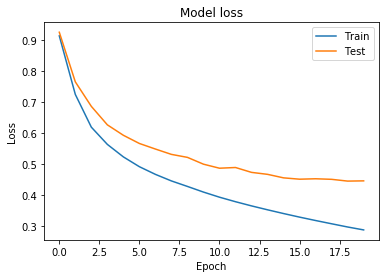

In [20]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [21]:
# in terminal
# tensorboard --logdir ./Graph